# Lasso regression on data smoothed with Gaussian (n = 10)

In [1]:
library(tidyverse)

library(glmnet)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Warning message in install.packages("tidyr"):
“installation of package ‘

### Read in data and ATAC values, add ATAC values to the dataframe

In [16]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_CONTROLS.csv", nrows=50000)
all_samples_gaussian_controls <- read.csv(snakemake@input[["input_train_data_std"]])

In [17]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_gaussian_controls <- inner_join(all_samples_gaussian_controls, ATAC, by="bin")

head(all_samples_ATAC_gaussian_controls)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X692,X693,X694,X695,X696,X697,X698,X699,X700,ATAC_observed
PGDX16568P,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5866651
PGDX16568P,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.1996134
PGDX16568P,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5968816
PGDX16568P,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2905764
PGDX16568P,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2319729
PGDX16568P,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2262170


In [18]:
ATAC_val <- all_samples_ATAC_gaussian_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_gaussian_controls %>% select(sample, bin)
all_samples_ATAC_gaussian_controls = all_samples_ATAC_gaussian_controls %>% select(-c(ATAC_observed, sample, bin))

## Finding the best lambda

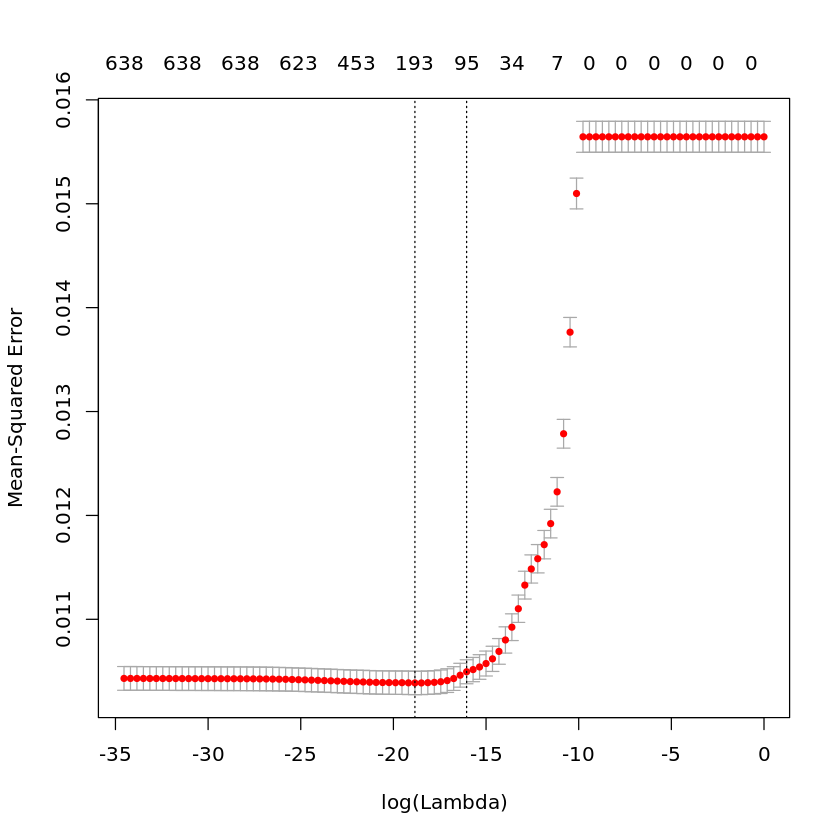

In [19]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
#head(X)

lambdas_to_try <- 10^seq(-18, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = FALSE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [20]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 6.579332e-09

In [21]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    
    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = FALSE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    #se    <- (observed-predicted)^2
    #mse   <- mean(se)
    #(rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [23]:
(res_lasso_gaussian_pred_controls <- CV_lasso_smooth(all_samples_ATAC_gaussian_controls, 10))

observed,predicted
0.5866651,0.4834314
0.1996134,0.3581986
0.5968816,0.4575175
0.2905764,0.3488510
0.2319729,0.3815257
0.2262170,0.3918880
0.3546569,0.4174829
0.4456518,0.4672886
0.4719340,0.4848421
0.4991555,0.4662451


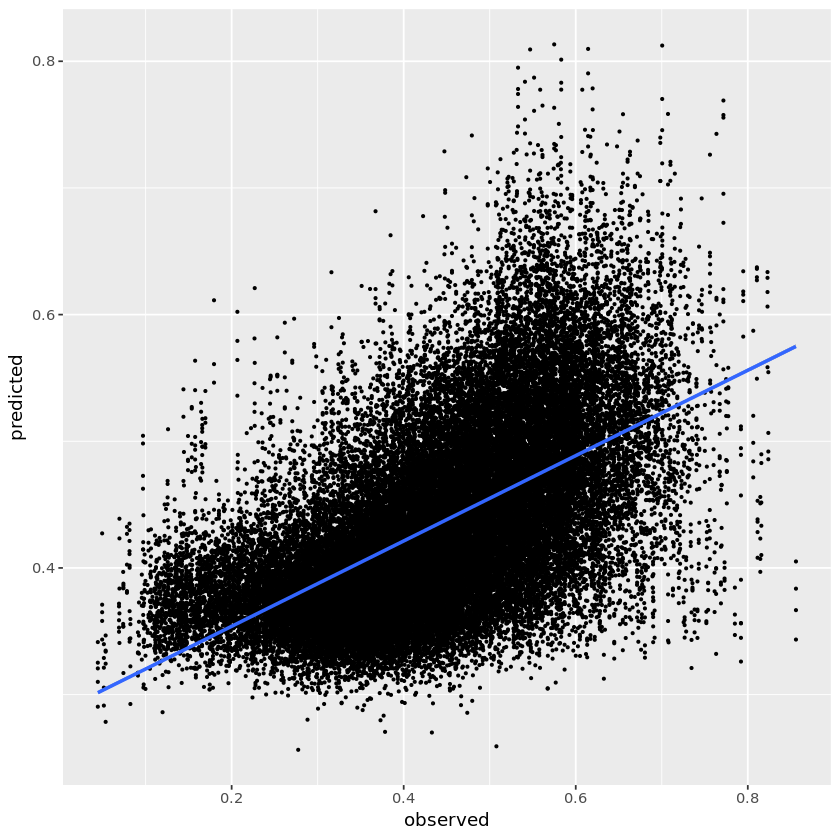

In [24]:
ggplot(res_lasso_gaussian_pred_controls, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [25]:
cor(res_lasso_gaussian_pred_controls$observed, res_lasso_gaussian_pred_controls$predicted)

# Standardize = TRUE: ATAC_val 0.6947938
# Standardize = FALSE: ATAC_val 0.6962595

ATAC_observed,0.5796762


## Save the predictions made with CV on controls to file

In [26]:
res_lasso_gaussian_pred_controls <- controls_predictions %>% mutate(ATAC_observed = res_lasso_gaussian_pred_controls$observed, 
                                                                    ATAC_predicted = res_lasso_gaussian_pred_controls$predicted)

head(res_lasso_gaussian_pred_controls)


sample,bin,ATAC_observed,ATAC_predicted
PGDX16568P,chr10_400,0.5866651,0.4834314
PGDX16568P,chr10_40,0.1996134,0.3581986
PGDX16568P,chr10_4,0.5968816,0.4575175
PGDX16568P,chr10_401,0.2905764,0.3488510
PGDX16568P,chr10_402,0.2319729,0.3815257
PGDX16568P,chr10_403,0.2262170,0.3918880


In [ ]:
rm(controls_predictions)

In [ ]:
write.table(res_lasso_gaussian_pred_controls, snakemake@output[["output_pred"]], append = F, sep=',', col.names=T, row.names=F)

## Fit the model on all controls

In [27]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = FALSE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


rm(X)
rm(y)
#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)

## Predict on normalized smoothed cases using the model (fitted on all controls) and add the predictions to the file

In [28]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_CASES.csv"
filename = snakemake@input[["input_test_data_std"]]

In [29]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX10344P1,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
rm(small_test)

In [30]:
f <- function(df1, pos) {
    df1[3:673] <- lapply(df1[3:673], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    pred_tibble <- tibble(sample = df1$sample, bin = df1$bin)
    rm(df)
    rm(df1)
    pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
    pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)
    
    rm(tmp)
    #message(pred_tibble)
    write.table(pred_tibble, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)
}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())


Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
c("PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", 
"PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX10344P1", "PGDX

ERROR: Error in read_tokens_chunked_(data, callback, chunk_size, tokenizer, col_specs, : Evaluation error: target of assignment expands to non-language object.
